In [1]:
 ### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


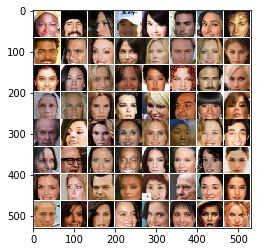

torch.Size([64, 3, 64, 64])


In [4]:
### LOAD DATA ###

dataloader, imsize = load(name='CelebA64', path='/home/shared/phase-retrieval/data/CelebA64.h5', batch_size=64)

sample = next(iter(dataloader['train']))
plot_grid(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [5]:
### LOAD MODEL ###

gen = models.DCGenerator(ngpu=1, ngf=128, nz=100, nc=3)
gen.load_state_dict(torch.load("/home/shared/phase-retrieval/models/DCGAN_CelebA/netG_epoch_99.pth"));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


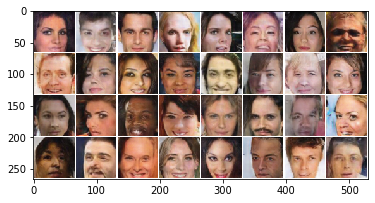

In [6]:
### Test model ###

gen.to(device)
plot_grid(gen(torch.randn((32, 100, 1, 1), device=device)).cpu().detach()*0.5+0.5)

In [7]:
### Load end-to-end model ###

dcnet = models.ConvNet(imsize=imsize, outsize=imsize, s=64)

# TODO: map storage location to correct GPU!
dcnet.load_state_dict(torch.load("/home/shared/phase-retrieval/models/CNNnet_CelebA/ConvNet64CelebA_1_0.011.sd",
                                 map_location={'cuda:1': device.__str__()}));

Version 0.6
Additional padding to fit 2 exp: (0, 0)
Kern size: 4096


In [8]:
### Hand Paper (adapted) ###

measurements = 500
A = (torch.randn(imsize[1] * imsize[2], measurements) / measurements).to(device)

def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

def calc_meas(x):
    N = x.shape[0]
    C = x.shape[1]
    compressed = (x.view(N, C, -1) @ A).view(N, C, measurements)
    return torch.abs(compressed)

def genopt(sample_magnitudes, gen, device, measurement_fn=calc_mags, 
           z_shape=(100, 1, 1), init_x=None, init_steps=0, init_lr=1e-1, 
           optim_lr=1e-1, max_steps=5000, max_loss=0.05):
    
    gen.to(device)
    gen.eval()
    
    N = sample_magnitudes.shape[0]
    z = torch.randn((N, *z_shape), requires_grad=True, device=device)

    optimizer = optim.Adam([z], lr=optim_lr)
    
    if init_x is not None:
        optimizer2 = optim.Adam([z], lr=init_lr)       
        loss = torch.sum(torch.mean((gen(z, unit_interval=True) - init_x) ** 2, 
                                    dim =tuple(np.arange(len(init_x.shape))[1:])))
        
        print("Initial init loss:", loss.item())
        for i in range(init_steps):
            optimizer2.zero_grad()
            loss.backward()
            optimizer2.step()
            loss = torch.sum(torch.mean((gen(z, unit_interval=True) - init_x) ** 2,
                                        dim =tuple(np.arange(len(init_x.shape))[1:])))
        print("Final init loss:", loss.item())
    
    losses = []
    last_out = gen(z, unit_interval=True)
    
    for i in range(max_steps):
 
        magnitudes = measurement_fn(last_out)
        mse_all = torch.mean((magnitudes - sample_magnitudes) ** 2, dim=tuple(np.arange(len(magnitudes.shape))[1:]))
        loss = torch.sum(mse_all)
        
        if loss < max_loss:
            break

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = gen(z, unit_interval=True)

        losses.append(loss.detach().cpu().item())
        
    return last_out.detach(), losses, mse_all


def genopt2(sample_magnitudes, gen, device, measurement_fn=calc_mags, 
            z_shape=(100, 1, 1), init_x=None, lmb=1e-1, optim_lr=1e-1, 
            max_steps=5000, max_loss=0.05):
    
    gen.to(device)
    gen.eval()
    
    N = sample_magnitudes.shape[0]
    z = torch.randn((N, *z_shape), requires_grad=True, device=device)

    criterion = nn.MSELoss()
    criterion2 = nn.MSELoss()
    optimizer = optim.Adam([z], lr=optim_lr)
    
    losses = []
    last_out = gen(z, unit_interval=True)
    
    for i in range(max_steps):
 
        magnitudes = measurement_fn(last_out)
        mse_all = torch.mean((magnitudes - sample_magnitudes) ** 2, dim =tuple(np.arange(len(magnitudes.shape))[1:]))
        loss = torch.sum(mse_all)
        if init_x is not None:
            loss = loss + lmb * torch.sum(torch.mean((gen(z, unit_interval=True) - init_x) ** 2,
                                                     dim =tuple(np.arange(len(init_x.shape))[1:])))
        
        if loss < max_loss:
            break

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = gen(z, unit_interval=True)

        losses.append(loss.detach().cpu().item())
        
    return last_out.detach(), losses, mse_all

In [ ]:
### Test one sample Fourier magnitudes random init + multiple restarts ###

num_batches = 16
batch_size = 64
max_steps = 10000
max_loss = 0.0
optim_lr = 1e-1
restarts = 3

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)

for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_magnitudes = calc_mags(test_sample)   
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
    
    for r in range(restarts):
        cur_out_results, cur_loss, cur_mse_all = genopt(sample_magnitudes=test_magnitudes, gen=gen, device=device,
                                                        optim_lr=optim_lr, max_steps=max_steps, max_loss=max_loss)
        cur_out_results = cur_out_results.cpu().numpy()

        for i in range(batch_size):
            mse = mse_all[batch_size * batch_i + i]
            if cur_mse_all[i] < mse:
                out_results[batch_size * batch_i + i] = cur_out_results[i]
                mse_all[batch_size * batch_i + i] = cur_mse_all[i]
    
    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

In [ ]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/DCGAN_CelebA/randomInit_original_3_1024.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/DCGAN_CelebA/randomInit_3_1024.p", "wb"))

In [24]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("/home/shared/phase-retrieval/test/DCGAN_CelebA/randomInit_original_3_1024.p", "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/DCGAN_CelebA/randomInit_3_1024.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


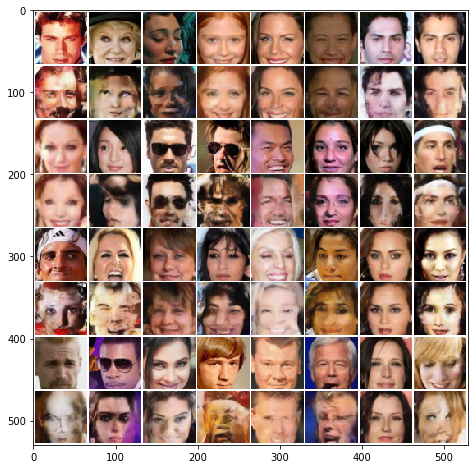

Signal error:
  MSE: 0.038760091852927794, std: 0.04266582240152212
  MAE: 0.13232689435638473, std: 0.07354905905692453
  SSIM: 0.5298675679461389, std: 0.19150734846741652
  FASI-MSE: 0.031072099946017603, std: 0.028994232418507043
  FASI-MAE: 0.12133733800775497, std: 0.05640979040488948
  COCO-MSE: 0.022116627858275666, std: 0.01559467174978253

Magnitude error:
  MSE Magnitude: 5.398276878548474, std: 2.5894858609847677

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [25]:
# Benchmark results

print("Output under minimized magnitude distance:")

to_plot = np.stack([out_original[:32].reshape(4, 8*3, 64, 64), 
                    out_results[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
           
plot_grid(to_plot, figsize=(8, 8),
          file="../out/dcgan/celeba/{0}{1}.png".format('randomInit_3_1024_', time.strftime("%Y%m%d_%H%M%S")))

benchmark(pred=out_results, true=out_original, check_all=True)

## Test Fourier magnitudes random init (64 samples)

| Nr Type | iterations | restarts | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 10000 | 3 | 1e-2 | 0.0396 | 0.135 | 0.509 | 0.0329 | 0.126 | 0.0227 | 5.853
| 2 | 10000 | 3 | 1e-3 | 0.0394 | 0.137 | 0.499 | 0.0340 | 0.129 | 0.0233 | 6.993
| 3 | 10000 | 3 | 1e-1 | 0.0345 | 0.127 | 0.516 | 0.0307 | 0.121 | 0.0230 | 5.777
| 4 | 10000 | 3 | 1.0 | 0.0489 | 0.158 | 0.382 | 0.0447 | 0.153 | 0.028 | 7.119


## Test Fourier magnitudes random init (1024 samples)

| Nr Type | iterations | restarts | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 3 | 10000 | 3 | 1e-1 | 0.03876 | 0.1323 | 0.5299 | 0.03107 | 0.1213 | 0.02211 | 5.398



In [ ]:
### Test one sample A measurements ###

num_batches = 16
batch_size = 64
max_steps = 10000
max_loss = 0.0
optim_lr= 1e-1
restarts = 3

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)


for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_measurements = calc_meas(test_sample)
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()

    for r in range(restarts):
        cur_out_results, cur_loss, cur_mse_all = genopt(sample_magnitudes=test_measurements, gen=gen,
                                                        device=device, measurement_fn=calc_meas, optim_lr=optim_lr,
                                                        max_steps=max_steps, max_loss=max_loss)
        cur_out_results = cur_out_results.cpu().numpy()
        
        for i in range(batch_size):
            mse = mse_all[batch_size * batch_i + i]
            if cur_mse_all[i] < mse:
                out_results[batch_size * batch_i + i] = cur_out_results[i]
                mse_all[batch_size * batch_i + i] = cur_mse_all[i]

    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

In [ ]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/DCGAN_CelebA/Ameas_original_3_1024.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/DCGAN_CelebA/Ameas_3_1024.p", "wb"))

In [26]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("/home/shared/phase-retrieval/test/DCGAN_CelebA/Ameas_original_3_1024.p", "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/DCGAN_CelebA/Ameas_3_1024.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


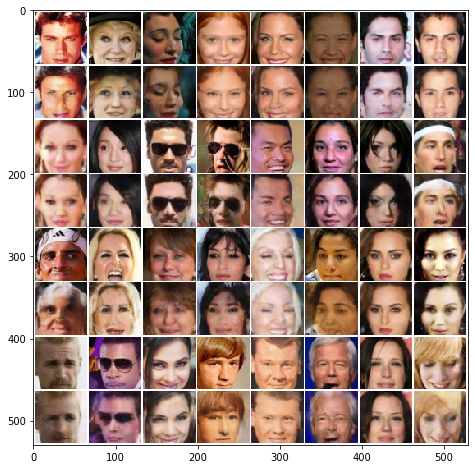

Signal error:
  MSE: 0.0045984641954802405, std: 0.002430366653099008
  MAE: 0.04959990365002975, std: 0.01171114342440774
  SSIM: 0.8055622186220103, std: 0.060867162169257756
  FASI-MSE: 0.004611298259191667, std: 0.0024663435248448475
  FASI-MAE: 0.04964229374621217, std: 0.01178382765667885
  COCO-MSE: 0.004598464195480224, std: 0.002430366653099012

Magnitude error:
  MSE Magnitude: 8.472437306770257, std: 4.61776434276378

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [27]:
print("Output under minimized magnitude distance:")

to_plot = np.stack([out_original[:32].reshape(4, 8*3, 64, 64), 
                    out_results[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
           
plot_grid(to_plot, figsize=(8, 8),
          file="../out/dcgan/celeba/{0}{1}.png".format('Ameas_3_1024_', time.strftime("%Y%m%d_%H%M%S")))

benchmark(pred=out_results, true=out_original, check_all=True)

## Test A measurements random init (64 samples)

| Nr Type | iterations | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 10000 | 1e-2 | 0.00520 | 0.0523 | 0.788 | 0.00520 | 0.0523 | 0.00520 | 9.589
| 2 | 10000 | 1e-3 | 0.00629 | 0.0567 | 0.765 | 0.00638 | 0.0569 | 0.00629 | 11.714
| 3 | 10000 | 1e-1 | 0.00504 | 0.0513 | 0.792 | 0.00505 | 0.0513 | 0.00504 | 9.259
| 4 | 10000 | 1.0 | 0.00682 | 0.0600 | 0.741 | 0.00685 | 0.0600 | 0.00682 | 11.766

## Test A measurements random init (1024 samples)

| Nr Type | iterations | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 3 | 10000 | 1e-1 | 0.004598 | 0.04959 | 0.8056 | 0.004611 | 0.04964 | 0.004598 | 8.472


In [ ]:
### Test one sample Fourier magnitudes with end-to-end init ###

num_batches = 16
batch_size = 64
max_steps = 10000
max_loss = 0.0
optim_lr= 1e-1
init_steps = 1000
init_lr= 1e-1

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)

for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_magnitudes = calc_mags(test_sample)
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()

    dcnet.to(device)
    dcnet.eval()
    init_x = dcnet(test_magnitudes).detach()

    cur_out_results, cur_loss, cur_mse_all = genopt(sample_magnitudes=test_magnitudes, gen=gen, device=device,
                                                    init_x=init_x, init_steps=init_steps, init_lr=init_lr,
                                                    optim_lr=optim_lr, max_steps=max_steps, max_loss=max_loss)
    cur_out_results = cur_out_results.cpu().numpy()
    
    out_results[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_out_results
    mse_all[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_mse_all.detach().cpu().numpy()
    
    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

In [ ]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/DCGAN_CelebA/e2eInit_original_3_1024.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/DCGAN_CelebA/e2eInit_3_1024.p", "wb"))

In [28]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("/home/shared/phase-retrieval/test/DCGAN_CelebA/e2eInit_original_3_1024.p", "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/DCGAN_CelebA/e2eInit_3_1024.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


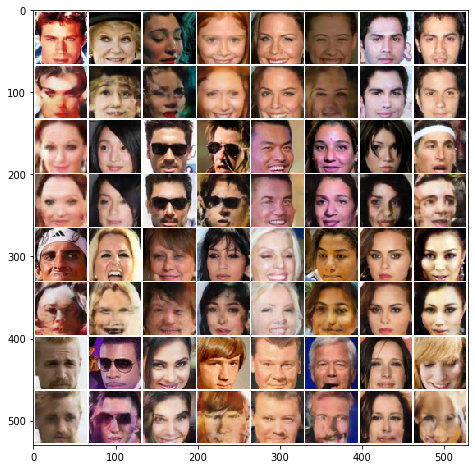

Signal error:
  MSE: 0.012056437995485338, std: 0.01303716623660698
  MAE: 0.07525584670044475, std: 0.03132062180727161
  SSIM: 0.7051142949572909, std: 0.12882394858770796
  FASI-MSE: 0.01294585947216068, std: 0.013933706271205817
  FASI-MAE: 0.07737592231448798, std: 0.03432576578983488
  COCO-MSE: 0.010978584292045526, std: 0.009400157612049842

Magnitude error:
  MSE Magnitude: 4.640451882158142, std: 2.4139633939365597

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [29]:
print("Output under minimized magnitude distance:")

to_plot = np.stack([out_original[:32].reshape(4, 8*3, 64, 64), 
                    out_results[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
           
plot_grid(to_plot, figsize=(8, 8),
          file="../out/dcgan/celeba/{0}{1}.png".format('e2eInit_3_1024_', time.strftime("%Y%m%d_%H%M%S")))

benchmark(pred=out_results, true=out_original, check_all=True)

## Test Fourier magnitudes end-to-end init (64 samples)

| Nr Type | init iterations | init lr |  iterations | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 1000 | 1e-1 | 10000 | 1e-2 | 0.0129 | 0.0782 | 0.687 | 0.0149 | 0.0823 | 0.0122 | 5.253
| 2 | 1000 | 1e-1 | 10000 | 1e-3 | 0.0130 | 0.0783 | 0.688 | 0.0141 | 0.0806 | 0.0122 | 5.609
| 3 | 1000 | 1e-1 | 10000 | 1e-1 | 0.0133 | 0.0800 | 0.673 | 0.0152 | 0.0840 | 0.0122 | 5.060
| 4 | 1000 | 1e-1 | 10000 | 1.0 | 0.0423 | 0.147 | 0.403 | 0.0428 | 0.150 | 0.0299 | 7.809

## Test Fourier magnitudes end-to-end init (1024 samples)

| Nr Type | init iterations | init lr |  iterations | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 3 | 1000 | 1e-1 | 10000 | 1e-1 | 0.01206 | 0.07526 | 0.7051 | 0.01295 | 0.07738 | 0.01098 | 4.640


In [ ]:
### Test one sample Fourier magnitudes with alternating FC init optimization and magnitude optimization ###

num_batches = 16
batch_size = 64
max_steps = 10000
max_loss = 0.0
optim_lr= 1e-1
lmb= 1e3

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))
mse_all = np.full((batch_size * num_batches), np.inf)

for batch_i, batch in enumerate(dataloader['test']):
    test_sample = batch.to(device)
    test_magnitudes = calc_mags(test_sample)
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()

    dcnet.to(device)
    dcnet.eval()
    init_x = dcnet(test_magnitudes).detach()

    cur_out_results, cur_loss, cur_mse_all = genopt2(sample_magnitudes=test_magnitudes, gen=gen, device=device,
                                                     init_x=init_x, lmb=lmb, optim_lr=optim_lr, max_steps=max_steps,
                                                     max_loss=max_loss)
    cur_out_results = cur_out_results.cpu().numpy()
    
    out_results[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_out_results
    mse_all[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_mse_all.detach().cpu().numpy()
    
    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break

plt.semilogy(cur_loss)
plt.show()

In [ ]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/DCGAN_CelebA/alternateOPt_original_3_1024.p", "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/DCGAN_CelebA/alternateOPt_3_1024.p", "wb"))

In [30]:
### LOAD RESULTS ###
import pickle

out_original = pickle.load(open("/home/shared/phase-retrieval/test/DCGAN_CelebA/alternateOPt_original_3_1024.p", "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/DCGAN_CelebA/alternateOPt_3_1024.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


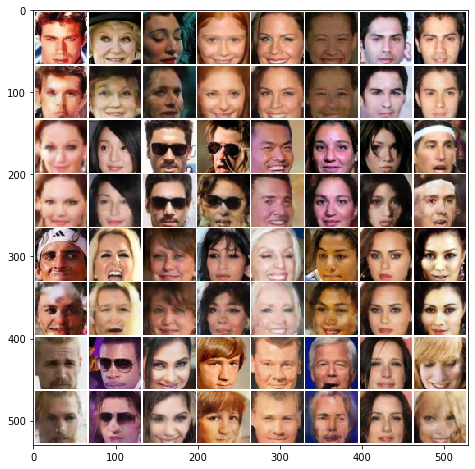

Signal error:
  MSE: 0.010391465453817155, std: 0.010600002157363916
  MAE: 0.06967043464285416, std: 0.02774701374891328
  SSIM: 0.7248035461039568, std: 0.11710498491752815
  FASI-MSE: 0.01130110931238262, std: 0.013245608591485155
  FASI-MAE: 0.07153723936421459, std: 0.03154830322586609
  COCO-MSE: 0.009665030721736932, std: 0.008301570067225013

Magnitude error:
  MSE Magnitude: 6.26773534050033, std: 3.3826029198984466

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]


In [31]:
print("Output under minimized magnitude distance:")

to_plot = np.stack([out_original[:32].reshape(4, 8*3, 64, 64), 
                    out_results[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
           
plot_grid(to_plot, figsize=(8, 8),
          file="../out/dcgan/celeba/{0}{1}.png".format('alternateOPt_3_1024_', time.strftime("%Y%m%d_%H%M%S")))

benchmark(pred=out_results, true=out_original, check_all=True)

## Test Fourier magnitudes alternate end-to-end vs. magnitude optimization (64 samples)

| Nr Type | iterations | lmd | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 10000 | 1e3 | 1e-2 | 0.0110 | 0.0727 | 0.703 | 0.0131 | 0.0774 | 0.0106 | 7.172
| 2 | 10000 | 1e3 | 1e-3 | 0.0123 | 0.0769 | 0.677 | 0.0156 | 0.0849 | 0.0116 | 8.421
| 3 | 10000 | 1e3 | 1e-1 | 0.0111 | 0.0724 | 0.706 | 0.0150 | 0.0805 | 0.0105 | 6.830
| 4 | 10000 | 1e3 | 1.0 | 0.0134 | 0.0815 | 0.646 | 0.0170 | 0.0895 | 0.0128 | 9.862


## Test Fourier magnitudes alternate end-to-end vs. magnitude optimization (1024 samples)

| Nr Type | iterations | lmd | lr | MSE | MAE | SSIM | FASI-MSE | FASI-MAE | COCO-MSE | MSE Magnitude
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 3 | 10000 | 1e3 | 1e-1 | 0.01039 | 0.06967 | 0.7248 | 0.01130 | 0.07153 | 0.009665 | 6.267